# Intent and Scenario Classification

# Problem definition

After learning the basics of Machine Learning in the Bachelor program in Economics and Computer Science I am attending at Bocconi University, I decided to apply to work on a project about text classification in order to acquire some skills in the field of Natural Language Processing.

The purpose of this project is to train an intent and scenario classifier that might be useful to support a chatbot. Intent and scenario lassification is an important component of Natural Language Understanding (NLU) systems in any chatbot platform.
As when you have an assistant and you tell him/her to book you a taxi, and your assistant knows how to respond for that query of yours because he/she has brain that trained for this, a chatbot providing assistance for a specific website has to be trained to respond for a particular query. To make a chatbot answer properly according to the users' question intent and scenario classifiers are developed and used.

The dataset used has been provided by [Open Search Network](https://www.opensearchnetwork.com) for an hackathon organized in collaboration with [Bocconi Students for Data Science](https://it.linkedin.com/company/bocconi-students-for-data-science), the organization I joined in order to enrich my competences in the field of Data Science and Machine Learning.

The dataset consists of 14514 questions with two labels, one determining the intent of the user and the other determining the scenario of the question. It is not a large dataset, however it is very well designed and contains a lot of information.

I plan to train two separate classifiers, an intent classifier and a scenario classifier.

# 1. Setup and dataset import

In this part, I upload the dataset and the libraries that are essential for the analysis and the training of the models I want to use.
If you want to run this notebook, I recommend you to save the dataset in the same directory as the copy of this notebook in order for the code below to run properly.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import spacy
import re
from sklearn.model_selection import GridSearchCV
from datetime import datetime

%matplotlib inline

I load the data in a single pandas `DataFrame` object and plan to separate the labels after carrying out the text processing for creating the features to give as input to the training algorithms for the machine learning models.

In [2]:
path = os.getcwd()

def load_data(data_path=path):
    csv_path = data_path + "/dataset_intent_train.csv"
    return pd.read_csv(csv_path, sep=";")

In [3]:
data = load_data()
data.head(2)

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query


I get a quick description of the data. As I anticipated, there are 14514 questions, each with two labels. There are no missing values, however, dealing with text data, I need anyway to carry out substantial data preprocessing in order to get the numerical features required by the training algorithms.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  14514 non-null  object
 1   scenario  14514 non-null  object
 2   intent    14514 non-null  object
dtypes: object(3)
memory usage: 340.3+ KB


In [5]:
data["scenario"].value_counts()

calendar          2094
play              1822
qa                1656
email             1230
iot                927
general            842
weather            739
transport          724
lists              690
news               592
datetime           502
social             499
recommendation     482
alarm              432
music              412
takeaway           295
cooking            291
audio              285
Name: scenario, dtype: int64

In [6]:
len(data["scenario"].value_counts())

18

In [7]:
data["intent"].value_counts()

query              4166
set                1213
music               841
quirky              740
factoid             736
remove              689
sendemail           482
radio               385
post                379
definition          353
recipe              289
currency            265
podcasts            265
events              225
createoradd         206
stock               189
locations           179
hue_lightoff        172
audiobook           167
ticket              167
game                164
hue_lightchange     157
querycontact        155
likeness            143
traffic             140
coffee              139
order               139
taxi                129
cleaning            120
volume_mute         114
maths               113
volume_up           101
hue_lightup          99
hue_lightdim         88
joke                 85
movies               78
wemo_off             69
convert              68
addcontact           62
settings             56
wemo_on              56
volume_down     

In [8]:
len(data["intent"].value_counts())

46

There are 18 scenario categories and 46 intent categories. Moreover, the intent variable is much more inbalanced than the scenario variable.

# 2. Train-test split and labels encoding

In this part, I perform the train-test split and the encoding of the scenario and intent labels.
For the train-test split, I do not shuffle the questions, because they are already shuffled and not re-shuffling them allows me to get the index separating training and test set, so that it will be easier to obtain them after vectorizing the text data.

In [9]:
train_set, test_set = train_test_split(data, test_size=0.2, shuffle = False)

In [10]:
train_set

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query
2,tell me about lisa ann,qa,factoid
3,play jumper by third eye blind,play,music
4,if there any alarm is set then let me know,alarm,query
...,...,...,...
11606,at what temperature should i bake cookies,cooking,recipe
11607,cut the songs in this musics,music,settings
11608,what is happening [date : tomorrow],recommendation,events
11609,show meetings,calendar,set


In [11]:
ind_train = len(train_set)
ind_train

11611

In [12]:
encoder_scenario = LabelEncoder()
encoder_intent = LabelEncoder()
y = encoder_scenario.fit_transform(data["scenario"])
z = encoder_intent.fit_transform(data["intent"])

In [13]:
y

array([ 0, 17, 12, ..., 11,  6,  7])

In [14]:
y.shape

(14514,)

In [15]:
encoder_scenario.classes_

array(['alarm', 'audio', 'calendar', 'cooking', 'datetime', 'email',
       'general', 'iot', 'lists', 'music', 'news', 'play', 'qa',
       'recommendation', 'social', 'takeaway', 'transport', 'weather'],
      dtype=object)

In [16]:
z

array([27, 27, 10, ..., 23, 29, 15])

In [17]:
z.shape

(14514,)

In [18]:
encoder_intent.classes_

array(['addcontact', 'audiobook', 'cleaning', 'coffee', 'convert',
       'createoradd', 'currency', 'definition', 'dislikeness', 'events',
       'factoid', 'game', 'greet', 'hue_lightchange', 'hue_lightdim',
       'hue_lightoff', 'hue_lighton', 'hue_lightup', 'joke', 'likeness',
       'locations', 'maths', 'movies', 'music', 'order', 'podcasts',
       'post', 'query', 'querycontact', 'quirky', 'radio', 'recipe',
       'remove', 'sendemail', 'set', 'settings', 'stock', 'taxi',
       'ticket', 'traffic', 'volume_down', 'volume_mute', 'volume_other',
       'volume_up', 'wemo_off', 'wemo_on'], dtype=object)

# 2. Text preprocessing

Regular expressions are strings with a special syntax/patterns which allow us to match pattern in other strings.
I use the compile method to compile syntax/patterns into pattern objects for which there are methods such as `search()` or `match()`.

In [19]:
pattern1 = re.compile("[\W]+")
pattern2 = re.compile("[\s]+")

Then, I use the Python built-in `lower.()` string method in order to make sure that all the words in the dataset questions have only lowercase letters, so that it is easier to detect patterns in the text data.

In [20]:
data["question"] = [entry.lower() for entry in data["question"]]
data.head(2)

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query


The `spaCy` library is used to perform some linguistic analysis during in the text preprocessing phase. Performing a good linguistic analysis according to the type of problem and the dataset is a crucial factor that can significantly affect the performance of the learning algorithms.

In [21]:
nlp = spacy.load("en")

`nlp` is the variable which stores `spaCy`'s pipeline.

 `nlp()` is called as a function on any text raw data, creating is an iterator over the sentences (if called on a text), or tokens (if called on a sentence). Each token has a range of properties, such as
- `text`: the actual word
- `lemma_`: the dictionary entry of a word
- `pos_`: the part of speech
- `dep`: dependency relation
- `is_punct`: check whether word is punctuation
- `is_stop`: check whether word is a stop word

Such an iterator is used to perform a number of analyses, such as
- tokenization
- sentence splitting
- lemmatization
- part-of-speech tagging
- dependency parsing
- named entity recognition

In particular, I will focus on the first 4 types of analysis.

#### Tokenization
Tokenizing text consists plitting a piece of text into words, symbols, punctuation, spaces and other elements, thereby creating “tokens”. A standard way to do this is to simply split the string on white space.
Thus, it is necessary to insert spaces into the text data since not all words are surrounded by white space, for example words at the beginning of the line have no space beforehand and words at the end of a phrase might have a punctuation symbol directly attached to them. This process is automatically done by the applications in the `spaCy` library.

#### Lemmatization
Lemmatization consists of reducing a word to its base form (dictionary form) to reduce variation, thereby making it potentially easier for the training algorithm of a machine learning model to detect patterns in the data. Different uses of a word often have the same root meaning. For example, "practice", "practised" and "practising" all essentially refer to the same idea. It is often desirable to standardize words with similar meaning to their base form, i.e to their *lemma*.

#### Part-of-speech tagging
Part-of-speech tagging consists of assigning grammatical properties, e.g. noun, verb, adverb, adjective etc., to words. 
We can distinguish between two types of words.
- *Content words* or *open class words* are words that possess semantic content and contribute to the meaning of the sentence in which they occur, and therefore belong to an "open" class, in the sense that this class acquires new members constantly (e.g. nous, verbs and adjectives). 
- *Function words* or *closed-class words* are words that do not have a meaning on their own but which help structuring a sentence, and therefore belong to a "closed" class, in the sense that this class acquires new members infrequently, if at all (e.g. pronouns and conjunctions).

Words that share the same POS tag tend to follow a similar syntactic structure and are useful in rule-based processes.

I now tokenize the text of the questions in the dataset in order to start structuring the training input data that will be given to the machine learning models.

In [22]:
tokens = [[token.text for token in nlp(question)] for question in data["question"].to_numpy()]

In [23]:
tokens

[['have', 'i', 'got', 'any', 'alarms', 'set'],
 ['what', "'s", 'the', 'current', 'temperature'],
 ['tell', 'me', 'about', 'lisa', 'ann'],
 ['play', 'jumper', 'by', 'third', 'eye', 'blind'],
 ['if', 'there', 'any', 'alarm', 'is', 'set', 'then', 'let', 'me', 'know'],
 ['get', 'me', 'an', 'uber', 'please'],
 ['should',
  'i',
  'go',
  'through',
  'the',
  'valley',
  'or',
  'on',
  'the',
  'ten',
  'to',
  'get',
  'to',
  'westwood'],
 ['please',
  'play',
  'only',
  'songs',
  'from',
  'the',
  'genre',
  'rap',
  'in',
  'my',
  'playlist'],
 ['what', "'s", 'new', 'on', 'my', 'facebook', 'account'],
 ['please', 'crank', 'up', 'huey', 'lewis', 'and', 'the', 'news'],
 ['what', 'time', 'is', 'set', 'for', 'my', 'wake', 'up', 'alarm'],
 ['select', 'the', 'weather', 'option'],
 ['what', 'is', 'the', 'capital', 'of', 'new', 'hampshire'],
 ['what', 'is', 'garam', 'masala'],
 ['play', 'real', 'racing', 'three', 'game'],
 ['power', 'off'],
 ['i', 'want', 'to', 'listen', 'to', 'heavy', 'me

In order to exclude unnecessary information in the text data for learning, I decided to exclude all the punctuation, if any, substitute all the *content words* with the corresponding *lemma* and keep most *function words*, of which some of them are also so-called *stopwords*, i.e. words which do not provide much meaning on their own and occurr very often in a sentence (a list of English stopwords can be found [here](https://www.textfixer.com/tutorials/common-english-words.txt)), since I believe they can be useful to detect some patterns, in particular for intent classification, since one category of the intent variable is "query" and many queries contain words like what, where, which etc.

In [24]:
tokens_2 = []
for i in range(len(data['question'])):
    tokens_2.append([])
    for token in nlp(data['question'][i]):
        if token.pos_ != "PUNCT":
            if token.pos_ in {"NOUN", "VERB", "PROPN", "ADJ", "ADV"}:
                tokens_2[i].append(token.lemma_)
            if token.pos_ in {"PRON", "PREP", "DET", "PART", "ADP", "CCONG", "X"}:
                tokens_2[i].append(token.text)
    if tokens_2[i] == []:
        tokens_2[i] = tokens[i]

In [25]:
tokens_2

[['i', 'get', 'any', 'alarm', 'set'],
 ['what', 'the', 'current', 'temperature'],
 ['tell', 'me', 'about', 'lisa', 'ann'],
 ['play', 'jumper', 'by', 'third', 'eye', 'blind'],
 ['there', 'any', 'alarm', 'set', 'then', 'let', 'me', 'know'],
 ['me', 'an', 'uber', 'please'],
 ['should',
  'i',
  'go',
  'through',
  'the',
  'valley',
  'on',
  'the',
  'to',
  'to',
  'westwood'],
 ['play',
  'only',
  'song',
  'from',
  'the',
  'genre',
  'rap',
  'in',
  'my',
  'playlist'],
 ['what', 'new', 'on', 'my', 'facebook', 'account'],
 ['crank', 'up', 'huey', 'lewis', 'the', 'news'],
 ['what', 'time', 'set', 'for', 'my', 'wake', 'up', 'alarm'],
 ['select', 'the', 'weather', 'option'],
 ['what', 'the', 'capital', 'of', 'new', 'hampshire'],
 ['what', 'garam', 'masala'],
 ['play', 'real', 'race', 'game'],
 ['power', 'off'],
 ['i', 'want', 'to', 'listen', 'to', 'heavy', 'metal'],
 ['where', 'johncena', 'from'],
 ['what', 'today', "'s", 'day'],
 ['play', 'stuff', 'you', 'should', 'know'],
 ['send'

In [26]:
clean_text = [' '.join([str(elem) for elem in question]) for question in tokens_2]

In [27]:
len(clean_text)

14514

# 3. Representations

We cannot pass text directly to train our models in Natural Language Processing, thus we need to convert it into numbers, which machine can understand and can perform the required modelling on it.
I now introduce different representations methods, i.e. methods of transforming tokenized text data into numerical feature vectors to be given to the training algorithms, that have different levels of sophistication, and then I will use all of them to train the classifiers and see how they can affect performance.

In [28]:
clean_text

['i get any alarm set',
 'what the current temperature',
 'tell me about lisa ann',
 'play jumper by third eye blind',
 'there any alarm set then let me know',
 'me an uber please',
 'should i go through the valley on the to to westwood',
 'play only song from the genre rap in my playlist',
 'what new on my facebook account',
 'crank up huey lewis the news',
 'what time set for my wake up alarm',
 'select the weather option',
 'what the capital of new hampshire',
 'what garam masala',
 'play real race game',
 'power off',
 'i want to listen to heavy metal',
 'where johncena from',
 "what today 's day",
 'play stuff you should know',
 'send email to',
 'i would like my to write original romantic message for my wife',
 'what time the first train depart from chicago',
 'show contact of john',
 'name all list',
 'what trend on social medium',
 'turn on my smart plug socket',
 'how the exchange rate for microsoft',
 'i would like to talk about it',
 'open spotifiy open workout',
 'remove my

## Bag-of-words representation

The *bag-of-words representation* is a simplifying representation, probably the least sophisticated one, used in NLP, according to which a text (such as a sentence or a document) is represented as the bag, i.e. multiset (a set allowing for multiple instances for each of its elements), of its words, disregarding grammar and even word order but keeping multiplicity.\
The bag-of-words representation is commonly used in methods of document classification, where the occurrence of each word in a text is the most crucial factor determining the text category. Thus, being this project focused on classification, I believe that this very simple type of representation will be sufficient to train a classifier with a good performance.

In order to count how many times a word occurs in a document or in a corpus of documents we can use the `CountVectorizer` transformer.\
It converts a collection of text documents to a matrix of token, n-gram or character n-gram counts, the so-called *count matrix*. An *n-gram* is a contiguous sequence of n tokens from a given sample of text, whereas a *character n-gram* is a contiguous sequence of n items from a given sample of text.\
Each row in the matrix represents a text, in our case a question, and each column the occurrence of a specific token or character n-gram: the resulting cells are the number of times that each token appears in each of the texts. We refer to the rows as *instances* and to columns as *features*.\
The parameter `analyzer` specifies whether the feature should be made of word or character n-grams. 

Since `CountVectorizer` already tokenizes the text it takes as input, in order to apply this tranformer I need to re-join all the tokens of the "cleaned" questions, i.e. the questions after standardizing characters type, reducing word variability and removing all the unnecessary information, into strings, by using the `clean_text` list previously defined.

I now use the `CountVectorizer` transformer to vectorize the questions with a count matrix for the occurrences of each word in each question.

In [29]:
vectorizer = CountVectorizer()
X_bag = vectorizer.fit_transform(clean_text)

In [30]:
X_bag

<14514x5590 sparse matrix of type '<class 'numpy.int64'>'
	with 82263 stored elements in Compressed Sparse Row format>

Being usually very sparse, the count matrix is represented in a compressed format by default, in order to avoid wasting that unnecessary memory accounting for all the zeros that would be used in a dense representation. In order to see the occurrence mapping through an indexed representation, I print the count matrix.

In [31]:
print(X_bag)

  (0, 2022)	1
  (0, 218)	1
  (0, 111)	1
  (0, 4422)	1
  (1, 5443)	1
  (1, 4975)	1
  (1, 1230)	1
  (1, 4939)	1
  (2, 4934)	1
  (2, 3045)	1
  (2, 13)	1
  (2, 2835)	1
  (2, 201)	1
  (3, 3721)	1
  (3, 2612)	1
  (3, 696)	1
  (3, 4998)	1
  (3, 1742)	1
  (3, 535)	1
  (4, 218)	1
  (4, 111)	1
  (4, 4422)	1
  (4, 3045)	1
  (4, 4987)	1
  (4, 4981)	1
  :	:
  (14509, 3261)	1
  (14510, 218)	1
  (14510, 111)	1
  (14510, 4422)	1
  (14510, 5443)	1
  (14510, 4987)	1
  (14510, 4994)	1
  (14511, 3454)	1
  (14511, 3256)	1
  (14511, 4604)	1
  (14511, 3914)	1
  (14511, 4926)	1
  (14512, 4975)	1
  (14512, 5566)	1
  (14512, 128)	1
  (14512, 4385)	1
  (14512, 2673)	1
  (14512, 1945)	1
  (14513, 3264)	1
  (14513, 3437)	1
  (14513, 5566)	1
  (14513, 2813)	1
  (14513, 4494)	1
  (14513, 448)	1
  (14513, 728)	1


In [32]:
X_bag.shape

(14514, 5590)

Since there are 5583 columns, we can conclude that there are 5583 different words in all the questions in the dataset. In order to fully understand the above indexed representation, it is necessary to know the index of each word in the matrix, accessible via the mapping from vector position to feature names given by the method `get_feature_names()` or via the mapping from feature names to vector positions given by the attribute `vocabulary_`.

In [33]:
print(vectorizer.get_feature_names())

['aa', 'aaj', 'aamir', 'aaron', 'abbas', 'abc', 'abdul', 'aberdeen', 'abhi', 'abject', 'able', 'abolish', 'abortion', 'about', 'aboutthe', 'above', 'abraham', 'abrupt', 'abs', 'absolute', 'abuse', 'abut', 'ac', 'academy', 'acceleration', 'accept', 'access', 'accident', 'accord', 'accordingly', 'account', 'accounting', 'accoustical', 'accumulate', 'accumulation', 'acdc', 'ace', 'acer', 'achieve', 'achievement', 'acme', 'acoustic', 'acquire', 'across', 'act', 'action', 'activate', 'active', 'activity', 'actor', 'actress', 'actual', 'actually', 'adam', 'adamgilchrist', 'adams', 'add', 'additional', 'address', 'adel', 'adele', 'adi', 'adjust', 'adjustable', 'adjustment', 'administrator', 'admission', 'adopter', 'advance', 'advantage', 'advertiser', 'advice', 'advise', 'aerosmith', 'afernoon', 'affair', 'affect', 'affleck', 'affordable', 'afghanistan', 'afi', 'africa', 'afte', 'after', 'afternnon', 'afternoon', 'aftyernoon', 'again', 'against', 'age', 'agenda', 'agent', 'agha', 'ago', 'agra

In [34]:
print(vectorizer.vocabulary_)

{'get': 2022, 'any': 218, 'alarm': 111, 'set': 4422, 'what': 5443, 'the': 4975, 'current': 1230, 'temperature': 4939, 'tell': 4934, 'me': 3045, 'about': 13, 'lisa': 2835, 'ann': 201, 'play': 3721, 'jumper': 2612, 'by': 696, 'third': 4998, 'eye': 1742, 'blind': 535, 'there': 4987, 'then': 4981, 'let': 2792, 'know': 2696, 'an': 181, 'uber': 5196, 'please': 3732, 'should': 4483, 'go': 2050, 'through': 5012, 'valley': 5286, 'on': 3454, 'to': 5049, 'westwood': 5435, 'only': 3459, 'song': 4613, 'from': 1946, 'genre': 2010, 'rap': 3993, 'in': 2383, 'my': 3264, 'playlist': 3727, 'new': 3328, 'facebook': 1744, 'account': 30, 'crank': 1174, 'up': 5242, 'huey': 2317, 'lewis': 2799, 'news': 3331, 'time': 5029, 'for': 1886, 'wake': 5363, 'select': 4389, 'weather': 5407, 'option': 3470, 'capital': 750, 'of': 3436, 'hampshire': 2149, 'garam': 1987, 'masala': 3010, 'real': 4014, 'race': 3949, 'game': 1980, 'power': 3803, 'off': 3437, 'want': 5377, 'listen': 2837, 'heavy': 2219, 'metal': 3098, 'where':

However, in order to give the matrix as input of some algorithms, it is necessary to consider the corresponding dense representation.

In [35]:
X_bag = np.array(X_bag.todense())

In [36]:
X_bag

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp \
https://dzone.com/articles/introduction-to-word-vectors \
https://towardsdatascience.com/a-brief-introduction-to-intent-classification-96fda6b1f557 \
http://cs229.stanford.edu/proj2017/final-reports/5163902.pdf

### Dimensionality reduction: Principal Component Analysis (PCA) vs Latent Semantic Analysis (LSA)

Given the sparse nature of the count matrix, a text will be a very sparsely populated vector in a very high-dimensional space, therefore it is likely that training instances obtained with the bags-of-words representation  lie within or close to a much lower-dimensional subspace. \
Thus, to make the data amenable to standard machine learning techniques, it is often recommended to reduce the dimension of the feature space while retaining as much information as possible. Moreover, in case of reduction to a 1-, 2- or 3-dimensional space, these techniques also allow for some data visualization.
A standard method for dimensionality reduction is *Principal Component Analysis (PCA)*, which, roughly speaking, projects a set of points onto a smaller dimensional affine subspace of “best fit”. In NLP, a similar technique known as *Latent Semantic Analysis (LSA)* or *Latent Semantic Indexing*, is frequently used. From a geometric perspective, this amounts to projecting onto a linear subspace instead of an affine subspace. From a computational perspective, both PCA and LSA are about computing Singular Value Decompositions (SVDs) of large matrices. It is natural to want to compare the utility of these two methods.

There is a [nice lecture](https://www.youtube.com/watch?v=QGd06MTRMHs&feature=youtu.be) by Andrew Ng on Stanford YouTube channel about different types of dimensionality reduction and in particular the comparison of PCA and LSA.

#### PCA

I apply PCA on the count matrix to identify all the principal components and check whether there are components that do not contribute to the variance.

In [37]:
pca = PCA()
pca.fit(X_bag)

PCA()

(1.0, 120.0)

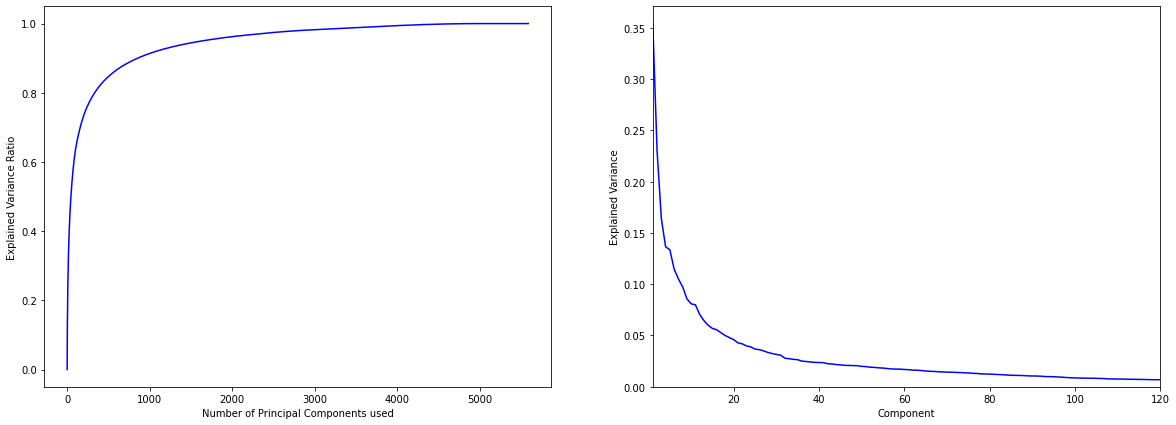

In [38]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
exp_var = np.zeros(len(pca.explained_variance_ratio_)+1)
exp_var[1:] = pca.explained_variance_ratio_
plt.plot(range(len(pca.explained_variance_ratio_)+1), np.cumsum(exp_var), "b-")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")

plt.subplot(1,2,2)
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, "b-")
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.ylim(ymin=0)
plt.xlim([1, 120])

The first graph represents the *explained variance ratio* (proportion of the count matrix variance) as a function of the number of principal components used. The second graph plots the variance explained by each principal component. By using the interactive visualization on the first graph (that appears right after executing the cell implementing the first graph), I can see that about 80% of the variance is explained by the first 350 principal components, therefore it would be convenient to use just these components to speed up the analysis.

For the sake of visualization, I will plot the first two components and the first three components to produce respectively a 2D scatterplot and a 3D scatterplot.

In [39]:
pca2d = PCA(n_components=2)
X_bag2d = pca2d.fit_transform(X_bag)

In [40]:
pca3d = PCA(n_components=3)
X_bag3d = pca3d.fit_transform(X_bag)
X_bag3d

array([[-0.42174508, -0.25873976, -0.02569723],
       [ 0.77541049, -0.34472237, -0.46095993],
       [-0.29329263, -0.14302608,  1.04384496],
       ...,
       [-0.34242639, -0.23111904, -0.08124275],
       [ 0.57337431, -0.09314459,  0.10115381],
       [-0.43168185, -0.06038531,  0.10635657]])

Text(0.5, 0.92, '3-dimensional PCA projection')

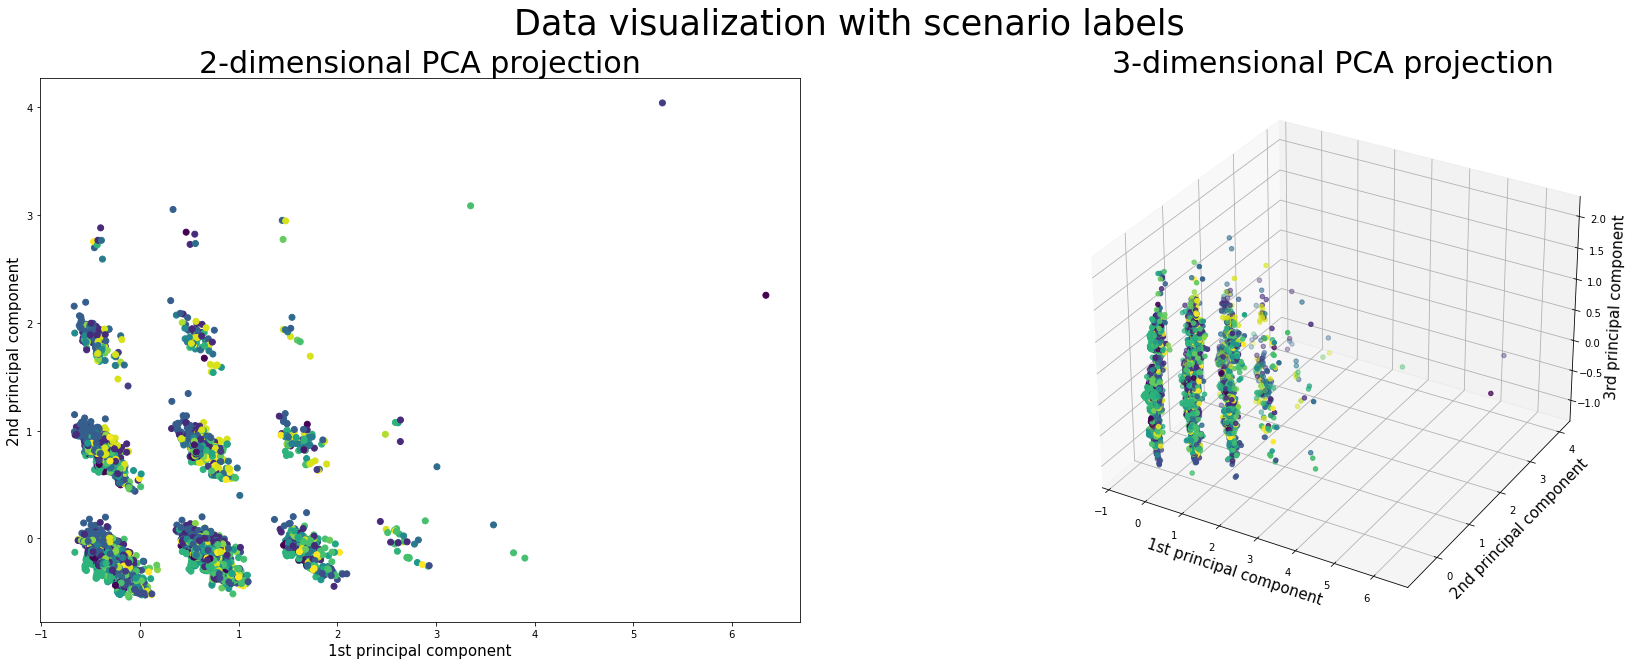

In [41]:
fig=plt.figure(figsize=(30, 10))

fig.suptitle('Data visualization with scenario labels', fontsize=35)

ax1=fig.add_subplot(1,2,1)
one=ax1.scatter(X_bag2d[:,0],X_bag2d[:,1],c=y)
ax1.set_xlabel('1st principal component',fontsize=15)
ax1.set_ylabel('2nd principal component',fontsize=15)
ax1.set_title('2-dimensional PCA projection',fontsize=30)

ax2=fig.add_subplot(1,2,2,projection='3d')
two=ax2.scatter(X_bag3d[:,0],X_bag3d[:,1],X_bag3d[:,2],c=y)
ax2.set_xlabel('1st principal component',fontsize=15)
ax2.set_ylabel('2nd principal component',fontsize=15)
ax2.set_zlabel('3rd principal component',fontsize=15)
ax2.set_title('3-dimensional PCA projection',fontsize=30)

Text(0.5, 0.92, '3-dimensional PCA projection')

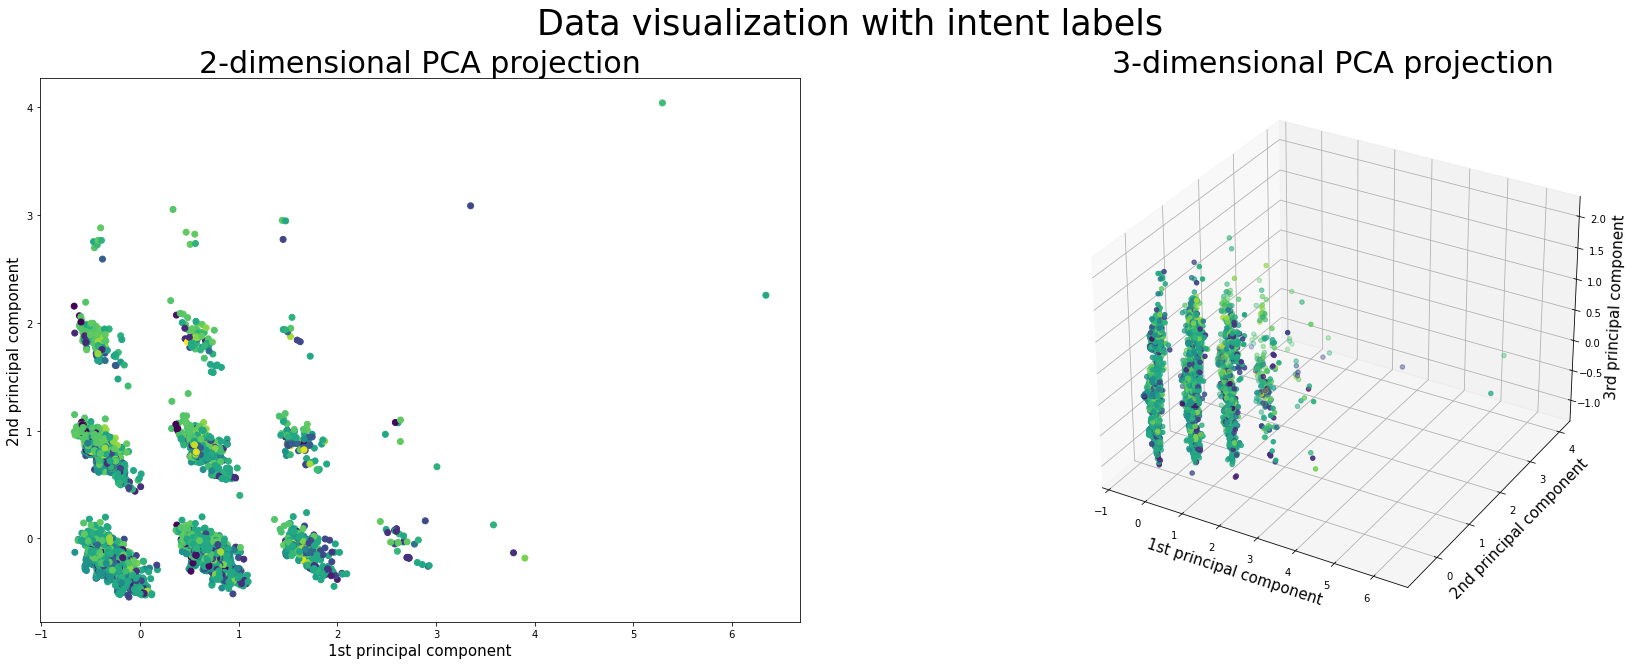

In [42]:
fig=plt.figure(figsize=(30, 10))

fig.suptitle('Data visualization with intent labels', fontsize=35)

ax1=fig.add_subplot(1,2,1)
one=ax1.scatter(X_bag2d[:,0],X_bag2d[:,1],c=z)
ax1.set_xlabel('1st principal component',fontsize=15)
ax1.set_ylabel('2nd principal component',fontsize=15)
ax1.set_title('2-dimensional PCA projection',fontsize=30)

ax2=fig.add_subplot(1,2,2,projection='3d')
two=ax2.scatter(X_bag3d[:,0],X_bag3d[:,1],X_bag3d[:,2],c=z)
ax2.set_xlabel('1st principal component',fontsize=15)
ax2.set_ylabel('2nd principal component',fontsize=15)
ax2.set_zlabel('3rd principal component',fontsize=15)
ax2.set_title('3-dimensional PCA projection',fontsize=30)

#### LSA

I carry out an analogue procedure for LSA. In Scikit-Learn, it is implemented by the `sklearn.decomposition.TrucatedSVD` transformer. As written in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), this transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In [43]:
lsa = TruncatedSVD(random_state=42)
lsa.fit(X_bag)

TruncatedSVD(random_state=42)

Text(0, 0.5, 'Explained Variance Ratio')

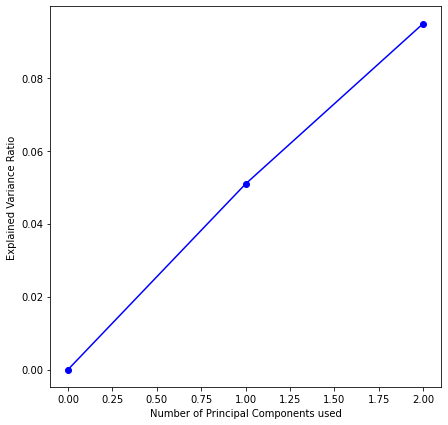

In [44]:
plt.figure(figsize=(7, 7))

exp_var = np.zeros(len(lsa.explained_variance_ratio_)+1)
exp_var[1:] = lsa.explained_variance_ratio_
plt.plot(range(len(lsa.explained_variance_ratio_)+1), np.cumsum(exp_var), "b-o")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")

In [45]:
lsa2d = TruncatedSVD(n_components=2, random_state=42)
X_baglsa2d = lsa2d.fit_transform(X_bag)

Text(0.5, 1.0, '2D visualization with intent labels')

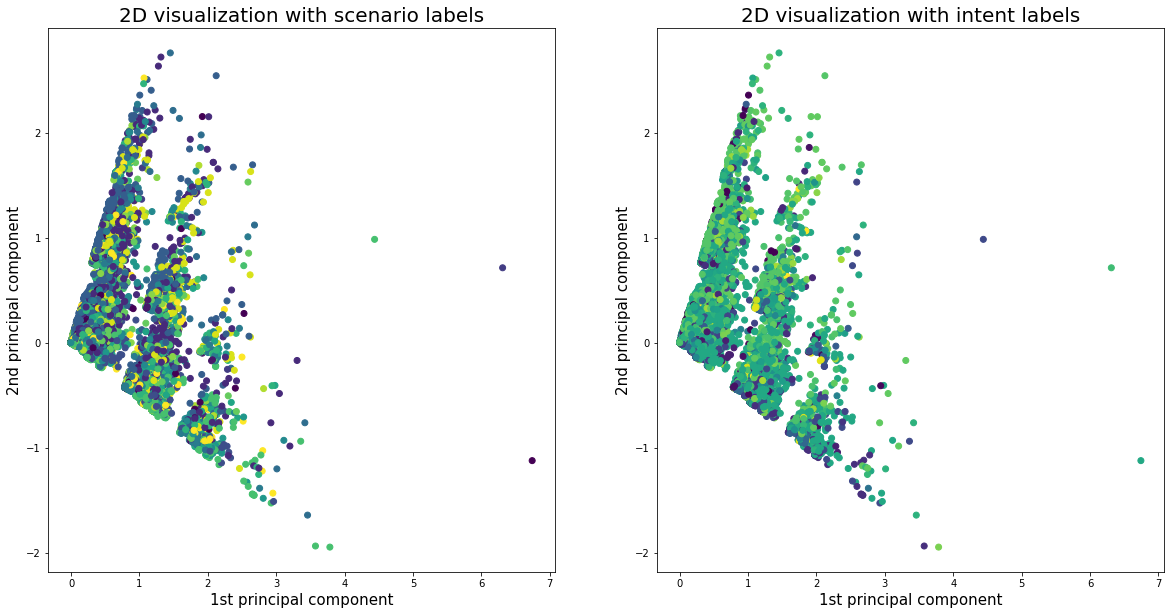

In [46]:
fig=plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(X_baglsa2d[:,0],X_baglsa2d[:,1],c=y)
plt.xlabel('1st principal component',fontsize=15)
plt.ylabel('2nd principal component',fontsize=15)
plt.title('2D visualization with scenario labels',fontsize=20)

plt.subplot(122)
plt.scatter(X_baglsa2d[:,0],X_baglsa2d[:,1],c=z)
plt.xlabel('1st principal component',fontsize=15)
plt.ylabel('2nd principal component',fontsize=15)
plt.title('2D visualization with intent labels',fontsize=20)

### Comments

From the visualization, we can see that both the scenario and intent classes do not look very well separated, which could most probably be due to the lack of sophistication of the bag-of-words representation.

## Word vectors

From the previous visualizations, we understood that bag-of-words representations, while useful for some machine learning (ML) tasks, are a very *naive* way of representing text data, since they only focus on word occurrences in a text without capturing information about a word's meaning or context and eventual potential relationships, such as contextual closeness.\
In contrast, *word vectors* represent words as multidimensional continuous floating point numbers where semantically similar words are mapped to proximate points in the vector space. That is, a word vector is a row of real-valued numbers, where each dimension captures an aspect of the word's meaning and therefore words that are used in a similar context are mapped to a proximate vector space.\
Besides being a more sophisticated representation, potentially capturing more information about a document than the bag-of-words representation, one important advantage of representing words as vectors is that they lend themselves to mathematical operators.

*Word2Vec* is an algorithm developed by Tomas Mikolov, et al. at Google in 2013, based on the distributional hypothesis: words occurring in similar linguistic contexts will also have similar semantic meaning.\
Thus, *Word2Vec* uses this idea to map words having similar semantic meaning geometrically close to each other in a N-Dimensional vector space, by training a group of shallow, 2-layer neural networks to reconstruct the linguistic context of words.\
Each unique word in the corpus vocabulary is assigned a unique corresponding vector in the space.

In [47]:
corpus = [sentence.split() for sentence in clean_text] 

In [48]:
corpus

[['i', 'get', 'any', 'alarm', 'set'],
 ['what', 'the', 'current', 'temperature'],
 ['tell', 'me', 'about', 'lisa', 'ann'],
 ['play', 'jumper', 'by', 'third', 'eye', 'blind'],
 ['there', 'any', 'alarm', 'set', 'then', 'let', 'me', 'know'],
 ['me', 'an', 'uber', 'please'],
 ['should',
  'i',
  'go',
  'through',
  'the',
  'valley',
  'on',
  'the',
  'to',
  'to',
  'westwood'],
 ['play',
  'only',
  'song',
  'from',
  'the',
  'genre',
  'rap',
  'in',
  'my',
  'playlist'],
 ['what', 'new', 'on', 'my', 'facebook', 'account'],
 ['crank', 'up', 'huey', 'lewis', 'the', 'news'],
 ['what', 'time', 'set', 'for', 'my', 'wake', 'up', 'alarm'],
 ['select', 'the', 'weather', 'option'],
 ['what', 'the', 'capital', 'of', 'new', 'hampshire'],
 ['what', 'garam', 'masala'],
 ['play', 'real', 'race', 'game'],
 ['power', 'off'],
 ['i', 'want', 'to', 'listen', 'to', 'heavy', 'metal'],
 ['where', 'johncena', 'from'],
 ['what', 'today', "'s", 'day'],
 ['play', 'stuff', 'you', 'should', 'know'],
 ['send'

In [49]:
# initialize model
w2v_model = Word2Vec(size=100, 
                     window=10,     #window= if i look at my target word in a window of 15 and find other words, which are then correlated with it 
                     hs=0,  #hierarchic sampling set to zero to have negative sampling
                     sample=0.000001,   #downsample frequent words by 0.000001 percent
                     negative=5, #for each words we draw 5 words with which they have never occurred with 
                     min_count=0,
                     workers=-1, #use all the available cores of the computer
                     iter=100 #how many time i go over each word in order to fin
)

w2v_model.build_vocab(corpus) # we collect statistics

w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs) # i train this model on the corpus #

(0, 0)

In [50]:
w2v_model.wv['alarm']  

array([ 2.7678540e-04, -2.9931867e-03, -4.8145638e-03,  4.9955552e-03,
       -4.4783843e-03, -3.8668059e-03,  7.9133158e-04, -2.4141397e-03,
       -1.2263396e-03,  1.8174791e-04,  4.8957462e-04, -4.5375600e-03,
        4.8283711e-03, -1.9701463e-03, -3.2634945e-03, -4.7194208e-03,
       -3.1172668e-03, -4.8461300e-03, -8.4802019e-04, -3.4892145e-03,
       -4.5151133e-03, -1.1942543e-03, -7.9713966e-04, -2.3205902e-03,
        3.6558716e-03,  8.7406940e-04,  2.2640292e-04, -4.9595623e-03,
       -2.5532851e-03, -4.8038800e-04, -4.8480774e-03, -8.2232774e-04,
        1.9039335e-03,  1.4217838e-04, -2.3415950e-03,  2.9157510e-03,
       -2.2436925e-03,  4.6357373e-03, -1.2468280e-03, -3.2048678e-04,
       -2.5263526e-03,  1.2812454e-03, -1.1113308e-03, -1.1690166e-03,
        4.3437826e-03, -2.7536347e-03, -4.1973656e-03, -3.0927213e-03,
       -4.9295877e-03,  4.2147394e-03,  2.3160083e-03, -3.4219385e-03,
       -3.3423421e-03, -2.6071062e-03,  4.8006489e-03, -4.6811388e-03,
      

In [51]:
w2v_model.wv[corpus[0]]

array([[-3.1600189e-03,  1.9478709e-03,  5.9383613e-04,  5.3256744e-04,
         4.3990160e-03, -2.2244726e-03,  4.7828308e-03, -4.8002824e-03,
         3.8525008e-04,  4.9217432e-03,  1.2166997e-03,  4.4375227e-04,
         4.5126458e-03,  4.4604854e-04,  3.6973935e-03, -2.4145807e-03,
        -1.5978264e-03,  5.1127863e-04,  4.5816866e-03, -3.9765644e-03,
         3.6715085e-03, -3.5490245e-03, -3.6442617e-03, -4.2546489e-03,
         2.1902390e-03, -2.5461167e-03,  4.2810771e-03,  2.9853338e-03,
         3.1377636e-03, -1.5511131e-03, -4.8792940e-03, -1.1426636e-03,
         3.9418759e-03,  3.6340821e-04,  4.1414559e-04, -1.5620418e-03,
         3.8242564e-03, -1.3227252e-03, -4.8158593e-03,  1.0479199e-03,
        -4.2790193e-03, -2.6438856e-03, -6.1713147e-04, -4.4730376e-03,
        -2.4872844e-03,  2.7467166e-03, -4.4258148e-03,  6.7346188e-04,
         4.1241073e-03,  2.0426260e-03, -4.9607479e-03, -4.3601650e-03,
         4.2012261e-04,  4.6682432e-03, -3.6622228e-03,  3.37939

I now use the classic approach of developing document embeddings, i.e. assigning a vector to each sentence, by summarizing word embeddings. In this case, I average the word vectors.

In [52]:
X_embed = []
i=0
for sentence in corpus:
    # remove out-of-vocabulary words
    doc = [word for word in sentence if word in w2v_model.wv.vocab]
    X_embed.append(np.mean(w2v_model.wv[doc], axis=0))

In [53]:
X_embed = np.array(X_embed)

In [54]:
X_embed

array([[-0.00086563,  0.00095294, -0.0009441 , ...,  0.00027099,
        -0.00070644, -0.00068074],
       [-0.00128663, -0.0018872 , -0.00123752, ..., -0.00068121,
         0.00068612,  0.00105829],
       [ 0.00168152, -0.00104924, -0.00146132, ..., -0.0004846 ,
         0.00289857,  0.00016912],
       ...,
       [ 0.00231576,  0.00244066,  0.00089142, ...,  0.00208792,
        -0.00278497, -0.00103174],
       [-0.00133223, -0.00197256, -0.00167125, ..., -0.00110964,
         0.00057065,  0.00086685],
       [ 0.0002496 , -0.000392  ,  0.00190682, ..., -0.00063528,
         0.00165915,  0.00051183]], dtype=float32)

### Dimensionality reduction: Principal Component Analysis (PCA) vs Latent Semantic Analysis (LSA)

I visualize the sentence representation developed by averaging word vectors using PCA and LSA as before.

#### PCA

In [55]:
pca_2 = PCA()
pca_2.fit(X_embed)

PCA()

(1.0, 120.0)

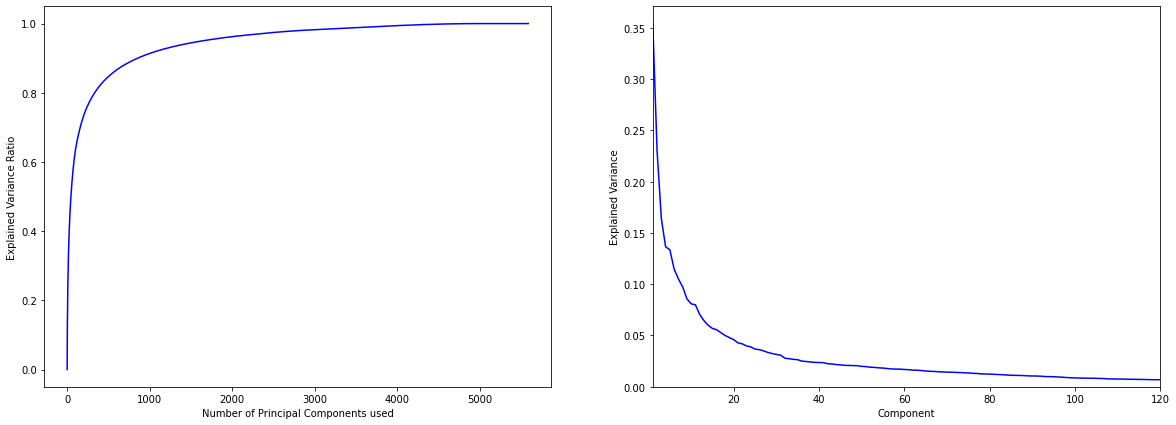

In [56]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
exp_var = np.zeros(len(pca.explained_variance_ratio_)+1)
exp_var[1:] = pca.explained_variance_ratio_
plt.plot(range(len(pca.explained_variance_ratio_)+1), np.cumsum(exp_var), "b-")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")

plt.subplot(1,2,2)
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, "b-")
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.ylim(ymin=0)
plt.xlim([1, 120])

In [57]:
pca2d_2 = PCA(n_components=2)
X_embed2d = pca2d_2.fit_transform(X_embed) 

In [58]:
pca3d_2 = PCA(n_components=3)
X_embed3d = pca3d_2.fit_transform(X_embed)
X_embed3d

array([[ 0.00066139, -0.00060343,  0.00401896],
       [ 0.00684138,  0.00281833,  0.00094173],
       [ 0.0021451 , -0.00113571, -0.00330169],
       ...,
       [-0.00359588,  0.00247085, -0.00212031],
       [ 0.0057079 , -0.00266654, -0.00242922],
       [-0.00207519, -0.00165615, -0.00091965]], dtype=float32)

Text(0.5, 0.92, '3-dimensional PCA projection')

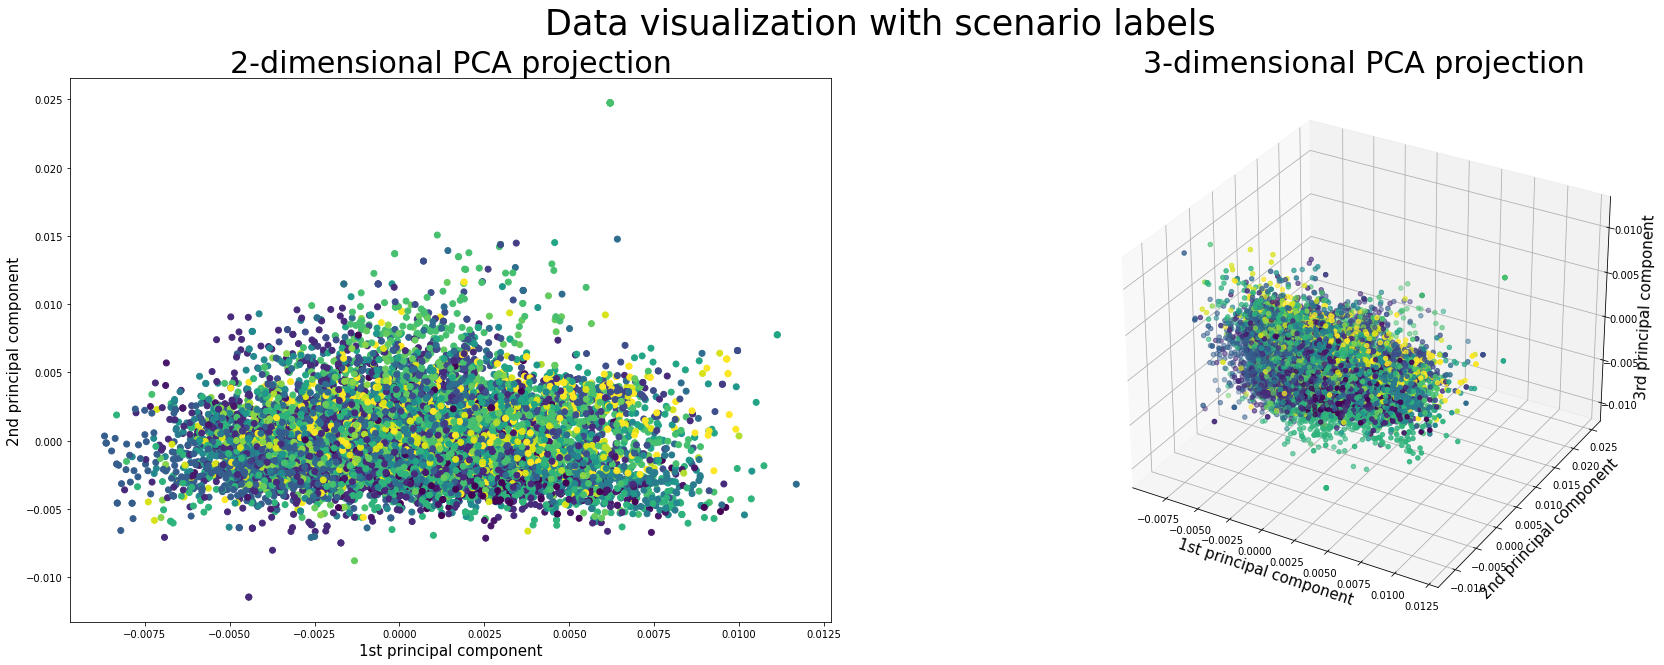

In [59]:
fig=plt.figure(figsize=(30, 10))

fig.suptitle('Data visualization with scenario labels', fontsize=35)

ax1=fig.add_subplot(1,2,1)
one=ax1.scatter(X_embed2d[:,0],X_embed2d[:,1],c=y)
ax1.set_xlabel('1st principal component',fontsize=15)
ax1.set_ylabel('2nd principal component',fontsize=15)
ax1.set_title('2-dimensional PCA projection',fontsize=30)

ax2=fig.add_subplot(1,2,2,projection='3d')
two=ax2.scatter(X_embed3d[:,0],X_embed3d[:,1],X_embed3d[:,2],c=y)
ax2.set_xlabel('1st principal component',fontsize=15)
ax2.set_ylabel('2nd principal component',fontsize=15)
ax2.set_zlabel('3rd principal component',fontsize=15)
ax2.set_title('3-dimensional PCA projection',fontsize=30)

Text(0.5, 0.92, '3-dimensional PCA projection')

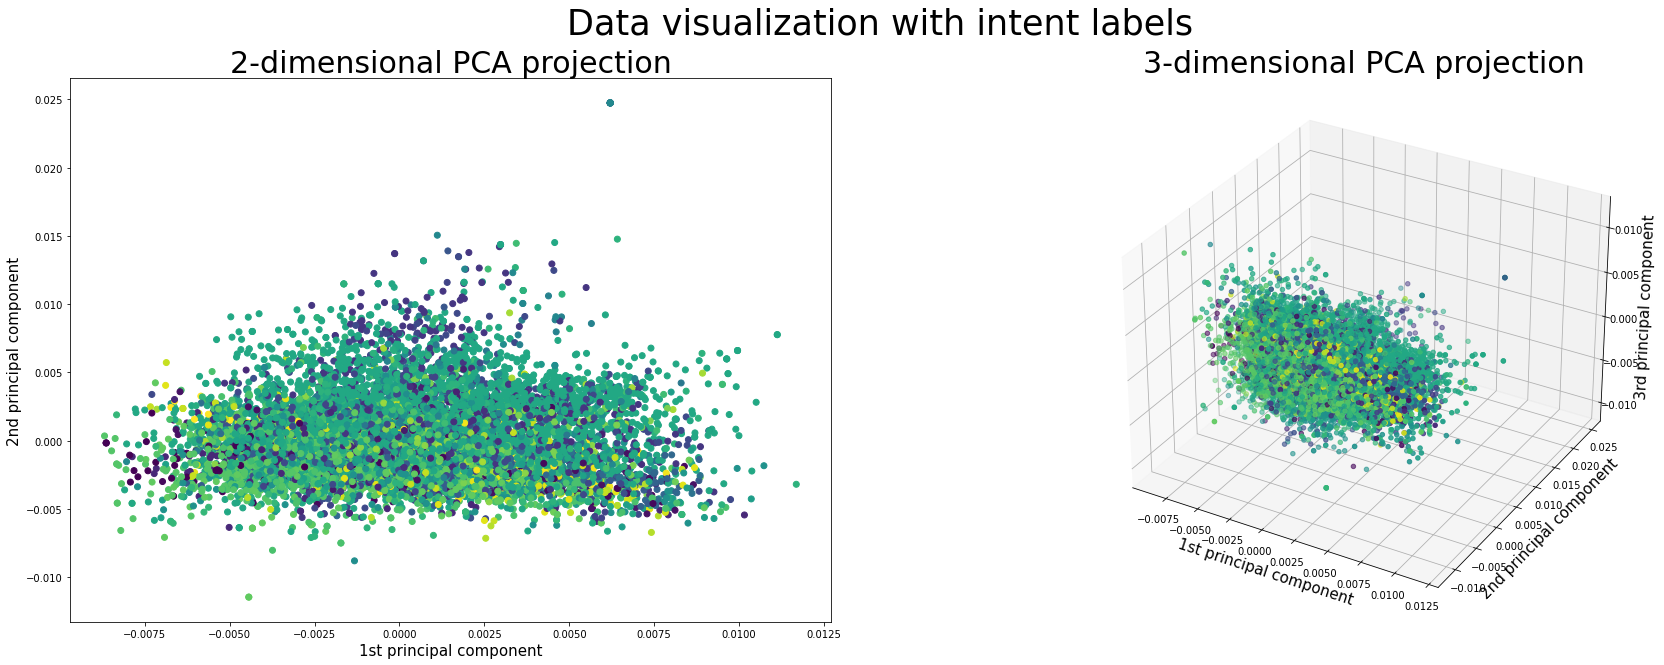

In [60]:
fig=plt.figure(figsize=(30, 10))

fig.suptitle('Data visualization with intent labels', fontsize=35)

ax1=fig.add_subplot(1,2,1)
one=ax1.scatter(X_embed3d[:,0],X_embed3d[:,1],c=z)
ax1.set_xlabel('1st principal component',fontsize=15)
ax1.set_ylabel('2nd principal component',fontsize=15)
ax1.set_title('2-dimensional PCA projection',fontsize=30)

ax2=fig.add_subplot(1,2,2,projection='3d')
two=ax2.scatter(X_embed3d[:,0],X_embed3d[:,1],X_embed3d[:,2],c=z)
ax2.set_xlabel('1st principal component',fontsize=15)
ax2.set_ylabel('2nd principal component',fontsize=15)
ax2.set_zlabel('3rd principal component',fontsize=15)
ax2.set_title('3-dimensional PCA projection',fontsize=30)

#### LSA

In [61]:
lsa_2 = TruncatedSVD(random_state=42)
lsa_2.fit(X_embed)

TruncatedSVD(random_state=42)

Text(0, 0.5, 'Explained Variance Ratio')

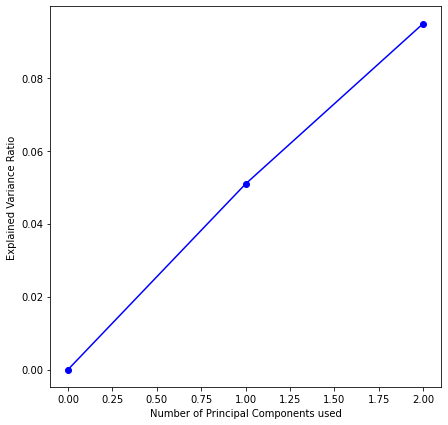

In [62]:
plt.figure(figsize=(7, 7))

exp_var = np.zeros(len(lsa.explained_variance_ratio_)+1)
exp_var[1:] = lsa.explained_variance_ratio_
plt.plot(range(len(lsa.explained_variance_ratio_)+1), np.cumsum(exp_var), "b-o")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")

In [63]:
lsa2d_2 = TruncatedSVD(n_components=2, random_state=42)
X_embedlsa2d = lsa2d_2.fit_transform(X_embed)

Text(0.5, 1.0, '2D visualization with intent labels')

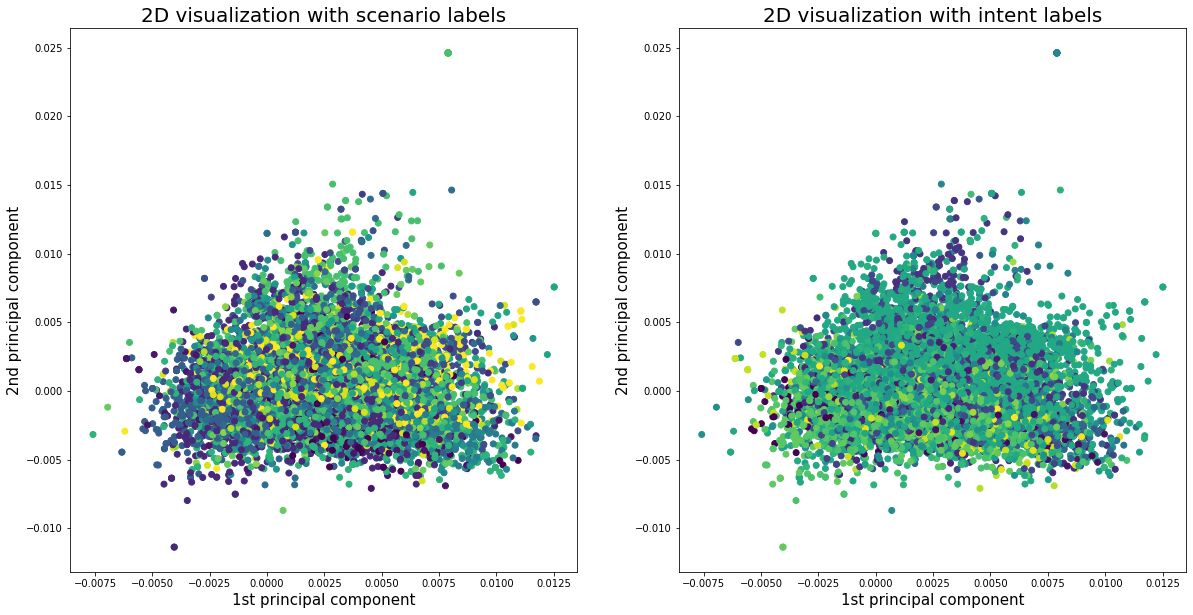

In [64]:
fig=plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(X_embedlsa2d[:,0],X_embedlsa2d[:,1],c=y)
plt.xlabel('1st principal component',fontsize=15)
plt.ylabel('2nd principal component',fontsize=15)
plt.title('2D visualization with scenario labels',fontsize=20)

plt.subplot(122)
plt.scatter(X_embedlsa2d[:,0],X_embedlsa2d[:,1],c=z)
plt.xlabel('1st principal component',fontsize=15)
plt.ylabel('2nd principal component',fontsize=15)
plt.title('2D visualization with intent labels',fontsize=20)

### Comments

From the visualization, we can see that both the scenario and intent classes do not look very well separated even in this case, maybe because the sentences that I am dealing with are very short to enable the algorithm to capture context patterns, therefore I prefer to use the bag-of-words representation to build the intent and scenario classifiers.

# 4. Models

I now fit some machine learning models to train an intent and classification classifier using the first 350 principal components of the PCA applied to the count matrix (bag-of-words representation).

In [65]:
X_train = X_bag[:ind_train]
X_test = X_bag[ind_train:]
y_train = y[:ind_train]
y_test = y[ind_train:]
z_train = z[:ind_train]
z_test = z[ind_train:]

In [66]:
pca350d = PCA(n_components = 350)
X_train = pca350d.fit_transform(X_train)
X_test = pca350d.transform(X_test)

## Random prediction

### Scenario classification

In [67]:
accuracy_score(y_test, np.random.randint(18, size=(2903,)))

0.05752669652084051

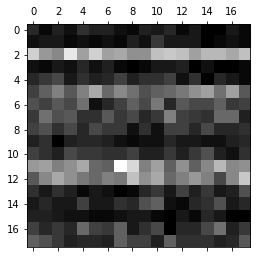

In [68]:
plt.matshow(confusion_matrix(y_test, np.random.randint(18, size=(2903,))), cmap=plt.cm.gray)
plt.show()

### Intent classification

In [69]:
accuracy_score(y_test, np.random.randint(46, size=(2903,)))

0.022735101619014812

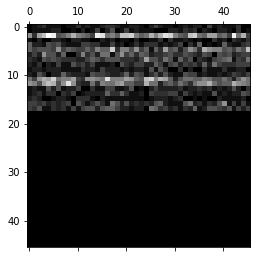

In [70]:
plt.matshow(confusion_matrix(y_test, np.random.randint(46, size=(2903,))), cmap=plt.cm.gray)
plt.show()

## Multilayer perceptron

### Scenario classification

In [71]:
clf_scenario = MLPClassifier(solver="adam", activation="relu", alpha=0.07, hidden_layer_sizes=(256), learning_rate="adaptive")

In [72]:
clf_scenario.fit(X_train, y_train)

MLPClassifier(alpha=0.07, hidden_layer_sizes=256, learning_rate='adaptive')

In [73]:
y_train_pred = clf_scenario.predict(X_train)
y_train_pred

array([ 0, 17, 12, ..., 13,  2,  5])

In [74]:
conf_mx = confusion_matrix(y_train, y_train_pred)

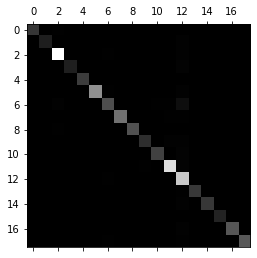

In [75]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [76]:
y_test_pred = clf_scenario.predict(X_test)
y_test_pred

array([15,  8, 16, ..., 11,  6,  7])

In [77]:
conf_mx_test = confusion_matrix(y_test, y_test_pred)

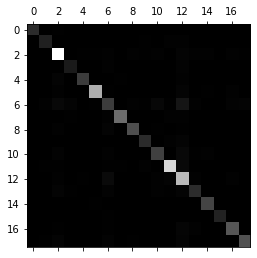

In [78]:
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.show()

In [79]:
accuracy_score(y_test, y_test_pred)

0.8566999655528763

### Intent classification

In [80]:
clf_intent = MLPClassifier(solver="adam", activation="relu", alpha=0.07, hidden_layer_sizes=(256), learning_rate="adaptive")

In [81]:
clf_intent.fit(X_train, z_train)

MLPClassifier(alpha=0.07, hidden_layer_sizes=256, learning_rate='adaptive')

In [82]:
z_train_pred = clf_intent.predict(X_train)
z_train_pred

array([27, 27, 10, ...,  9, 27, 28])

In [83]:
conf_mx = confusion_matrix(z_train, z_train_pred)

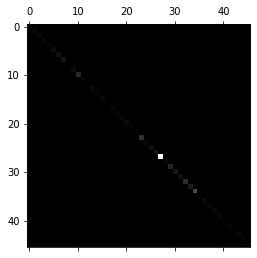

In [84]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
z_test_pred = clf_intent.predict(X_test)
z_test_pred

array([27,  5, 39, ..., 23, 29, 15])

In [86]:
conf_mx_test = confusion_matrix(z_test, z_test_pred)

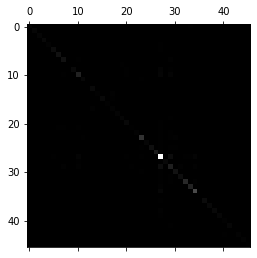

In [87]:
plt.matshow(conf_mx_test, cmap=plt.cm.gray)
plt.show()

In [88]:
accuracy_score(z_test, z_test_pred)

0.7926283155356528